In [79]:
# Data analysis and manipulation
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
# Calculates swing highs and lows
from scipy.signal import *
from scipy.signal import argrelextrema

# Plotting
import matplotlib.pyplot as plt
# To avoid warnings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# The short_selling library has all the functions defined in the previous notebooks
# import sys
# sys.path.append("/Users/liliaromanova/Downloads/QuantraShortSellingResources/data_modules/short_selling.py")
# from data_modules.short_selling import graph_regime_fc
# from data_modules.short_selling import swings
# from data_modules.short_selling import sma
# from data_modules.short_selling import read_data

import warnings
warnings.filterwarnings('ignore')

In [80]:
# Задаем тикер, валютную пару и индекс
ticker = 'AAPL'
currency = 'EUR=X'
index = 'SPY'
# Задаем диапазон дат в котором нужно собирать все данные по тикеру
start = dt.datetime(2020,1,1).date()
#end = dt.datetime(2010,12,31).date()
end = dt.datetime.today().date() # сегодняшняя дата, чтобы не менять вручную.
# Скачиваем данные по тикеру
df1 = pd.DataFrame(yf.download([ticker],start,end))
df2 = pd.DataFrame(yf.download([currency],start,end)['Close']).rename(columns ={'Close' : 'Currency'})
df2.loc[df2['Currency'] >0, 'Currency'] = 1   # Раскоментить это если не нужно валютных пар
df3 = pd.DataFrame(yf.download([index],start,end)['Close']).rename(columns ={'Close' : 'Index'})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [81]:
# Concatenates the three dataframes
df = pd.concat([df1, df2, df3], axis=1)
df.dropna(inplace=True)
df.head(4)

,Open,High,Low,Close,Adj Close,Volume,Currency,Index
Date,,,,,,,,
2019-12-31,72.482498,73.419998,72.379997,73.412498,72.443558,100805600.0,1.0,321.859985
2020-01-02,74.059998,75.150002,73.797501,75.087502,74.096443,135480400.0,1.0,324.869995
2020-01-03,74.287498,75.144997,74.125000,74.357498,73.376083,146322800.0,1.0,322.410004
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.960770,118387200.0,1.0,323.640015


In [82]:
# Calculate the product of benchmark and currency using '*'
df['adjustment_factor'] = df['Currency']*df['Index']
# Calculate relative open
df['relative_open'] = df['Open']/df['adjustment_factor']
# Calculate relative high
df['relative_high'] = df['High']/df['adjustment_factor']
# Calculate relative low
df['relative_low'] = df['Low']/df['adjustment_factor']
# Calculate relative close
df['relative_close'] = df['Close']/df['adjustment_factor']
# Returns the top 2 rows of the dataframe
df.head(2)

,Open,High,Low,Close,Adj Close,Volume,Currency,Index,adjustment_factor,relative_open,relative_high,relative_low,relative_close
Date,,,,,,,,,,,,,
2019-12-31,72.482498,73.419998,72.379997,73.412498,72.443558,100805600.0,1.0,321.859985,321.859985,0.225199,0.228112,0.22488,0.228088
2020-01-02,74.059998,75.150002,73.797501,75.087502,74.096443,135480400.0,1.0,324.869995,324.869995,0.227968,0.231323,0.22716,0.231131


In [83]:
# Calculate rebased open
df['rebased_open'] = df['relative_open']*df['adjustment_factor'].iloc[0]
# Calculate rebased high
df['rebased_high'] = df['relative_high']*df['adjustment_factor'].iloc[0]
# Calculate rebased low
df['rebased_low'] = df['relative_low']*df['adjustment_factor'].iloc[0]
# Calculate rebased close
df['rebased_close'] = df['relative_close']*df['adjustment_factor'].iloc[0]
# Round all the values in the dataset upto two decimal places
df= round(df,2)
# Returns the top 2 rows of the dataframe 
df.head(2)

,Open,High,Low,Close,Adj Close,Volume,Currency,Index,adjustment_factor,relative_open,relative_high,relative_low,relative_close,rebased_open,rebased_high,rebased_low,rebased_close
Date,,,,,,,,,,,,,,,,,
2019-12-31,72.48,73.42,72.38,73.41,72.44,100805600.0,1.0,321.86,321.86,0.23,0.23,0.22,0.23,72.48,73.42,72.38,73.41
2020-01-02,74.06,75.15,73.80,75.09,74.10,135480400.0,1.0,324.87,324.87,0.23,0.23,0.23,0.23,73.37,74.45,73.11,74.39


In [84]:
# Calculate swings
def swings(df, high, low, argrel_window):

    # Create swings:

    # Step 1: copy existing df. We will manipulate and reduce this df and want to preserve the original
    high_low = df[[high, low]].copy()

    # Step 2: build 2 lists of highs and lows using argrelextrema
    highs_list = argrelextrema(
        high_low[high].values, np.greater, order=argrel_window)
    lows_list = argrelextrema(
        high_low[low].values, np.less, order=argrel_window)

    # Step 3: Create swing high and low columns and assign values from the lists
    swing_high = 's' + str(high)[-12:]
    swing_low = 's' + str(low)[-12:]
    high_low[swing_low] = high_low.iloc[lows_list[0], 1]
    high_low[swing_high] = high_low.iloc[highs_list[0], 0]

# Alternation: We want highs to follow lows and keep the most extreme values

    # Step 4. Create a unified column with peaks<0 and troughs>0
    swing_high_low = str(high)[:2]+str(low)[:2]
    high_low[swing_high_low] = high_low[swing_low].sub(
        high_low[swing_high], fill_value=0)

    # Step 5: Reduce dataframe and alternation loop
    # Instantiate start
    i = 0
    # Drops all rows with no swing
    high_low = high_low.dropna(subset=[swing_high_low]).copy()
    while ((high_low[swing_high_low].shift(1) * high_low[swing_high_low] > 0)).any():
        # eliminate lows higher than highs
        high_low.loc[(high_low[swing_high_low].shift(1) * high_low[swing_high_low] < 0) &
                     (high_low[swing_high_low].shift(1) < 0) & (np.abs(high_low[swing_high_low].shift(1)) < high_low[swing_high_low]), swing_high_low] = np.nan
        # eliminate earlier lower values
        high_low.loc[(high_low[swing_high_low].shift(1) * high_low[swing_high_low] > 0) & (
            high_low[swing_high_low].shift(1) < high_low[swing_high_low]), swing_high_low] = np.nan
        # eliminate subsequent lower values
        high_low.loc[(high_low[swing_high_low].shift(-1) * high_low[swing_high_low] > 0) & (
            high_low[swing_high_low].shift(-1) < high_low[swing_high_low]), swing_high_low] = np.nan
        # reduce dataframe
        high_low = high_low.dropna(subset=[swing_high_low]).copy()
        i += 1
        if i == 4:  # avoid infinite loop
            break

    # Step 6: Join with existing dataframe as pandas cannot join columns with the same headers
    # First, we check if the columns are in the dataframe
    if swing_low in df.columns:
        # If so, drop them
        df.drop([swing_low, swing_high], axis=1, inplace=True)
    # Then, join columns
    df = df.join(high_low[[swing_low, swing_high]])

# Last swing adjustment:

    # Step 7: Preparation for the Last swing adjustment
    high_low[swing_high_low] = np.where(
        np.isnan(high_low[swing_high_low]), 0, high_low[swing_high_low])
    # If last_sign <0: swing high, if > 0 swing low
    last_sign = np.sign(high_low[swing_high_low][-1])

    # Step 8: Instantiate last swing high and low dates
    last_slo_dt = df[df[swing_low] > 0].index.max()
    last_shi_dt = df[df[swing_high] > 0].index.max()

    # Step 9: Test for extreme values
    if (last_sign == -1) & (last_shi_dt != df[last_slo_dt:][swing_high].idxmax()):
            # Reset swing_high to nan
        df.loc[last_shi_dt, swing_high] = np.nan
    elif (last_sign == 1) & (last_slo_dt != df[last_shi_dt:][swing_low].idxmax()):
        # Reset swing_low to nan
        df.loc[last_slo_dt, swing_low] = np.nan

    return (df)

In [85]:
data = swings(df, high='rebased_high', low='rebased_low', argrel_window=20)
data.tail(2)

,Open,High,Low,Close,Adj Close,Volume,Currency,Index,adjustment_factor,relative_open,relative_high,relative_low,relative_close,rebased_open,rebased_high,rebased_low,rebased_close,srebased_low,srebased_high
Date,,,,,,,,,,,,,,,,,,,
2021-09-10,155.00,155.48,148.70,148.97,148.97,140646400.0,1.0,445.44,445.44,0.35,0.35,0.33,0.33,112.00,112.34,107.45,107.64,NaN,112.34
2021-09-13,150.63,151.42,148.75,149.55,149.55,102271300.0,1.0,446.58,446.58,0.34,0.34,0.33,0.33,108.56,109.13,107.21,107.78,NaN,NaN


In [86]:
# Copy swing lows and highs to a smaller dataframe called regime
regime = data[(data['srebased_low'] > 0) | (data['srebased_high'] > 0)][[
    'rebased_close', 'srebased_low', 'srebased_high']].copy()
regime.tail(2)

,rebased_close,srebased_low,srebased_high
Date,,,
2021-08-27,106.23,104.96,NaN
2021-09-10,107.64,NaN,112.34


In [87]:
# Calculate volatility from main dataframe and populate regime dataframe
regime['stdev'] = round(data['rebased_close'].rolling(window=63, min_periods=63).std(0), 2)
regime.tail(2)

,rebased_close,srebased_low,srebased_high,stdev
Date,,,,
2021-08-27,106.23,104.96,NaN,4.44
2021-09-10,107.64,NaN,112.34,3.16


In [88]:
# Instantiate columns based on absolute and relative series
# Relative series (Check the first letter of 'close')
close = 'rebased_close'
if str(close)[0] == 'r':
    regime_cols = ['r_floor', 'r_ceiling', 'r_regime_change',
                   'r_regime_floorceiling', 'r_floorceiling', 'r_regime_breakout']
# Absolute series
else:
    regime_cols = ['floor', 'ceiling', 'regime_change',
                   'regime_floorceiling', 'floorceiling', 'regime_breakout']
# Instantiate columns by concatenation
# Concatenate regime dataframe with a temporary dataframe with same index initialised at NaN
regime = pd.concat([regime, pd.DataFrame(np.nan, index=regime.index, columns=regime_cols)], axis=1)
regime.tail(2)

,rebased_close,srebased_low,srebased_high,stdev,r_floor,r_ceiling,r_regime_change,r_regime_floorceiling,r_floorceiling,r_regime_breakout
Date,,,,,,,,,,
2021-08-27,106.23,104.96,NaN,4.44,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-10,107.64,NaN,112.34,3.16,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
# Set floor and ceiling range to 1st swing
floor_ix = regime.index[0]
ceiling_ix = regime.index[0]

# Standard deviation threshold to detect the change
threshold = 1.5

# current_regime 0: Starting value 1: Bullish -1: Bearish
current_regime = 0

for i in range(1, len(regime)):

    # Ignores swing lows
    if regime['srebased_high'][i] > 0:
        # Find the highest high (srebased_high) from range floor_ix to current value
        top = regime[floor_ix:regime.index[i]]['srebased_high'].max()
        top_index = regime[floor_ix:regime.index[i]]['srebased_high'].idxmax()
        
        # (srebased_high - top) / stdev
        ceiling_test = round((regime['srebased_high'][i]-top)/regime['stdev'][i], 1)
        
        # Check if current value is 1.5 x standard devaition away from the top value
        if ceiling_test <= -threshold:
            
            # Set ceiling = top and celing_ix to index (id)
            ceiling = top
            ceiling_ix = top_index
            
            # Assign ceiling
            regime.loc[ceiling_ix, 'r_ceilling'] = ceiling

            # If the current_regime is not bearish
            # The condition will satisfy 
            # And we will change the regime to bearish and set current_regime to -1            
            if current_regime != -1:
                rg_change_ix = regime['srebased_high'].index[i]
                _rg_change = regime['srebased_high'][i]
                
                # Prints where/n ceiling found
                regime.loc[rg_change_ix, 'r_regime_change'] = _rg_change
                # Regime change
                regime.loc[rg_change_ix, 'r_regime_floorceiling'] = -1

                # Test for floor/ceiling breakout
                regime.loc[rg_change_ix, 'r_floorceiling'] = ceiling
                current_regime = -1


    # Ignores swing highs
    if regime['srebased_low'][i] > 0:
        # Lowest swing low from ceiling
        bottom = regime[ceiling_ix:regime.index[i]]['srebased_low'].min()
        bottom_index = regime[ceiling_ix:regime.index[i]]['srebased_low'].idxmin()

        floor_test = round((regime['srebased_low'][i]-bottom)/regime['stdev'][i], 1)

        if floor_test >= threshold:
            floor = bottom
            floor_ix = bottom_index
            regime.loc[floor_ix, 'r_floor'] = floor

            if current_regime != 1:
                rg_change_ix = regime['srebased_low'].index[i]
                _rg_change = regime['srebased_low'][i]
                
                # Prints where/n floor found
                regime.loc[rg_change_ix, 'r_regime_change'] = _rg_change
                # regime change
                regime.loc[rg_change_ix, 'r_regime_floorceiling'] = 1
                # Test for floor/ceiling breakout
                regime.loc[rg_change_ix, 'r_floorceiling'] = floor

                current_regime = 1

In [90]:
# Join regime to data using the function 'df1.join((df2), on='Date', how='outer')
data = data.join(regime[regime_cols], on='Date', how='outer')
data.head(2)

,Open,High,Low,Close,Adj Close,Volume,Currency,Index,adjustment_factor,relative_open,...,rebased_low,rebased_close,srebased_low,srebased_high,r_floor,r_ceiling,r_regime_change,r_regime_floorceiling,r_floorceiling,r_regime_breakout
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,72.48,73.42,72.38,73.41,72.44,100805600.0,1.0,321.86,321.86,0.23,...,72.38,73.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,74.06,75.15,73.80,75.09,74.10,135480400.0,1.0,324.87,324.87,0.23,...,73.11,74.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Forward fill 'regime_floorceiling','regime_change' and 'floorceiling'
c=['r_regime_floorceiling', 'r_regime_change', 'r_floorceiling']
data[c] = data[c].fillna(method='ffill').fillna(0)

In [92]:
# Look for highest close for every floor/ceiling
close_max = data.groupby(['r_floorceiling'])['rebased_close'].cummax()
# Look for lowest close for every floor/ceiling
close_min = data.groupby(['r_floorceiling'])['rebased_close'].cummin()

In [93]:
# Assign the lowest close for regime bull and highest close for regime bear
rgme_close = np.where(data['r_floorceiling'] < data['r_regime_change'], close_min,
                      np.where(data['r_floorceiling'] > data['r_regime_change'], close_max, 0))

In [94]:
# Subtract from floor/ceiling & replace nan with 0
data['r_regime_breakout'] = (rgme_close - data['r_floorceiling']).fillna(0)
# If sign == -1 : bull breakout or bear breakdown
data['r_regime_breakout'] = np.sign(data['r_regime_breakout'])
# Regime change
data['r_regime_change'] = np.where(np.sign(
    data['r_regime_floorceiling']*data['r_regime_breakout']) == -1, 
                                   data['r_floorceiling'], data['r_regime_change'])
# Re-assign floorceiling
data['r_regime_floorceiling'] = np.where(np.sign(
    data['r_regime_floorceiling']*data['r_regime_breakout']) == -1, 
                                         data['r_regime_breakout'], data['r_regime_floorceiling'])

# Returns the top two rows of dataset
data.head(2)

,Open,High,Low,Close,Adj Close,Volume,Currency,Index,adjustment_factor,relative_open,...,rebased_low,rebased_close,srebased_low,srebased_high,r_floor,r_ceiling,r_regime_change,r_regime_floorceiling,r_floorceiling,r_regime_breakout
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,72.48,73.42,72.38,73.41,72.44,100805600.0,1.0,321.86,321.86,0.23,...,72.38,73.41,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2020-01-02,74.06,75.15,73.80,75.09,74.10,135480400.0,1.0,324.87,324.87,0.23,...,73.11,74.39,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [95]:
# Calculate simple moving average
def sma(df,price, ma_per,min_per,decimals):
    '''
    Returns the simple moving average.
    price: column within the df
    ma_per: moving average periods
    min_per: minimum periods (expressed as 0<pct<1) to calculate moving average
    decimals: rounding number of decimals
    
    
    '''
    sma = round(df[price].rolling(window= ma_per,min_periods= int(round(ma_per*min_per,0))).mean(),decimals)
    return sma   

In [96]:
# Declare variables
short_term = 50
mid_term = 200
min_per = 1

# Calculate short term moving average, short_term_ma
data['short_term_ma'] = sma(df=data, price='rebased_close',
                            ma_per=short_term, min_per=min_per, decimals=2)
# Calculate mid term moving average, mid_term_ma
data['mid_term_ma'] = sma(df=data, price='rebased_close',
                          ma_per=mid_term, min_per=min_per, decimals=2)

# Returns the bottom two rows of the dataset
data.tail(2)

,Open,High,Low,Close,Adj Close,Volume,Currency,Index,adjustment_factor,relative_open,...,srebased_low,srebased_high,r_floor,r_ceiling,r_regime_change,r_regime_floorceiling,r_floorceiling,r_regime_breakout,short_term_ma,mid_term_ma
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-10,155.00,155.48,148.70,148.97,148.97,140646400.0,1.0,445.44,445.44,0.35,...,NaN,112.34,NaN,NaN,104.96,1.0,94.33,1.0,107.66,105.37
2021-09-13,150.63,151.42,148.75,149.55,149.55,102271300.0,1.0,446.58,446.58,0.34,...,NaN,NaN,NaN,NaN,104.96,1.0,94.33,1.0,107.76,105.40


In [97]:
# Plot regime
def graph_regime_fc(ticker,df,y,th,sl,sh,clg,flr,bs,rg,st,mt,bo):
     
    fig = plt.figure(figsize=(20,10))
    ax1 = plt.subplot2grid((1,1), (0,0))

    date = df.index
    close = df[y]
    swing_low = df[sl]
    swing_high = df[sh]
    ceiling = df[clg]
    floor = df[flr]
    
    base = df[bs]
    regime = df[rg]
    
    ax1.plot_date(df.index, close,'-', color='k',  label=ticker.upper()+' stdev:'+str(th)) 
    ax1.plot(df.index, swing_low,'.' ,color='r', label= 'swing low',alpha=0.5)
    ax1.plot(df.index, swing_high,'.' ,color='g', label= 'swing high',alpha=0.5)    
    plt.scatter(df.index, floor,c='b',marker='^',label='floor')
    plt.scatter(df.index, ceiling,c='m',marker='v',label='ceiling')
        
    ax1.plot([],[],linewidth=5, label= 'bear', color='m',alpha=0.1)
    ax1.plot([],[],linewidth=5 , label= 'bull', color='b',alpha=0.1)
    ax1.fill_between(date, close, base,where=((regime==1)&(close>base)), facecolor='b', alpha=0.1)
#     ax1.fill_between(date, close, base,where=((regime==1)&(close<base)), facecolor='b', alpha=0.8)
    ax1.fill_between(date, close, base,where=((regime==-1)&(close<base)), facecolor='m', alpha=0.1)
#     ax1.fill_between(date, close, base,where=((regime==-1)&(close>base)), facecolor='m', alpha=0.8)
    
    if np.sum(st) >0 :
        ax1.plot(df.index, st,'-' ,color='lime', label= ' st')
        ax1.plot(df.index, mt,'-' ,color='green', label= ' mt') # 2. plot line
        # Profitable conditions
        ax1.fill_between(date,close, mt,where=((regime ==1)&(st>=mt)&(close>=mt)), 
                     facecolor='green', alpha=0.3) 
        ax1.fill_between(date,close, mt,where=((regime==-1)&(st<=mt)&(close<=mt)), 
                     facecolor='red', alpha=0.3)
        # Unprofitable conditions
        ax1.fill_between(date,close, mt,where=((regime ==1)&(st>=mt)&(close<mt)), 
                     facecolor='darkgreen', alpha=1) 
        ax1.fill_between(date,close, mt,where=((regime==-1)&(st<=mt)&(close>mt)), 
                     facecolor='darkred', alpha=1)
    
    if bo > 0:
#         ax1.plot([],[],linewidth=5, label=str(bo)+' days high', color='m',alpha=0.3)
#         ax1.plot([],[],linewidth=5, label=str(bo) + ' days low', color='b',alpha=0.3)
        rolling_min= close.rolling(window=bo).min()
        rolling_max= close.rolling(window=bo).max()
        ax1.fill_between(date, close, rolling_min,
                         where=((regime ==1)&(close > rolling_min)), facecolor='b', alpha=0.2)
        ax1.fill_between(date,close, rolling_max,
                         where=((regime ==-1)&(close < rolling_max)), facecolor='m', alpha=0.2)
        ax1.plot(df.index, rolling_min,'-.' ,color='b', label= str(bo)+' low',alpha=0.5)
        ax1.plot(df.index, rolling_max,'-.' ,color='m', label= str(bo)+' low',alpha=0.5)


    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.grid(True)
    ax1.xaxis.label.set_color('g')
    ax1.yaxis.label.set_color('g')

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.title('Floor and Ceiling', fontsize=16)
    plt.legend()

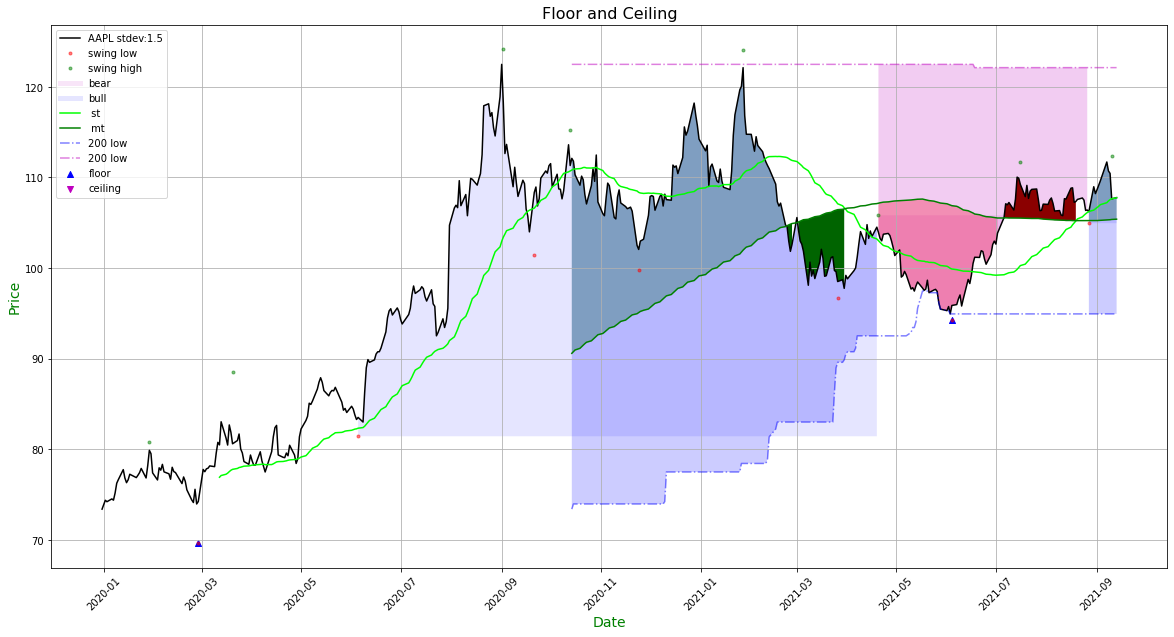

In [98]:
# Plot the graph for relative series
graph_regime_fc(ticker=ticker, df=data, y='rebased_close', th=1.5, sl='srebased_low', sh='srebased_high',
                clg='r_ceiling', flr='r_floor', bs='r_regime_change', rg='r_regime_floorceiling', 
                st=data['short_term_ma'], mt=data['mid_term_ma'], bo=200)